# DDPG　仕様変更の確認

<div class="notebook-data">
<div class="author">Ogawa</div>
<div class="company">GRID</div>
<div class="date">2019/1/25</div>
<div class="description">
</div>
</div>

## Conclusion

DDQN logger successful.

## Import necessary packages tutorial

In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import renom as rm
from renom.utility.initializer import Uniform, GlorotUniform
from renom_rl.continuous.ddpg import DDPG
from old.ddpg import DDPG as DDPG_old
from renom_rl.environ.openai import Pendulum


## Deifne the environment tutorial

In [2]:
from copy import deepcopy
env = Pendulum()
env2 = Pendulum()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/mikeogawa/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Users/mikeogawa/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Define the actor network tutorial

In [3]:
class Actor(rm.Model):
    
    '''Here considered 3-layer network (excluding input layer). Feel free to change the network depth 
    and check the results. The output-layer number of nuerons are equal to number of actions.
    In the example of OpenAI Gym's Pendlum-v0 environment number of actions are 1.'''
    
    def __init__(self, layer_size):
        self._layers = []
        self.action_size = 1
        self.high = 2.
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(self.action_size, initializer=Uniform(min=-0.003, max=0.003))
    
    def forward(self, x):
        '''Neural Network inputs are state information, outputs are actions. '''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(h1))
        h3 = rm.tanh(self._l3(h2)) 
        h = h3*self.high
        return h


# Define the Critic network tutorial

In [4]:
class Critic(rm.Model):
    '''Here considered a 3-layer network (input layer, hidden layer-1, hidden layer-2, output layer)
        At input-layer state information, 2nd-hidden layer actions are applied, last layer has a single neuron'''
    def __init__(self, layer_size):        
        self._layers = []
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform(), weight_decay=0.01)
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform(), weight_decay=0.01)
        self._l3 = rm.Dense(1, initializer=Uniform(min=-0.0003, max=0.0003), weight_decay=0.01)
  
    def forward(self, x, action):
        '''Q(s,a) calculation for a given (state, action) pair'''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(rm.concat(h1, action))) # actions are applied at 2nd hidden layer
        h = self._l3(h2)        
        return h
    

## Instantiating the actor & ciritic networks 

In [5]:
layer_size = [400, 300] # two-hidden layers dimension
actor_network = Actor(layer_size=layer_size)
critic_network = Critic(layer_size=layer_size)

## Instantiating the DDPG class

In [6]:
ddpg = DDPG(env, actor_network, critic_network)
ddpg_old=DDPG_old(env2,deepcopy(actor_network),deepcopy(critic_network))

## Training 

## new

In [7]:
ddpg.fit(epoch=2, epoch_step=1000, random_step=50, test_step=100)

epoch 001 avg_loss:800.332 total_reward [train:-7671.455 test:-648.888] avg train reward in episode:0.000 e-rate:0.376: 100%|██████████| 1000/1000 [00:23<00:00, 42.76it/s]
epoch 002 avg_loss:100.407 total_reward [train:-7428.717 test:-754.795] avg train reward in episode:0.000 e-rate:0.000: 100%|██████████| 1000/1000 [00:25<00:00, 38.57it/s]


## old

In [8]:
ddpg_old.fit(epoch=2, epoch_step=1000, random_step=50, test_step=100)

epoch 001 avg_loss:23.630 total_reward [train:-5740.546 test:-591.686] avg train reward in episode:-1148.109 e-rate:0.376: 100%|██████████| 1000/1000 [00:16<00:00, 59.46it/s]
epoch 002 avg_loss:23.419 total_reward [train:-5632.490 test:-450.139] avg train reward in episode:-1126.498 e-rate:0.000: 100%|██████████| 1000/1000 [00:16<00:00, 60.75it/s]


## Testing

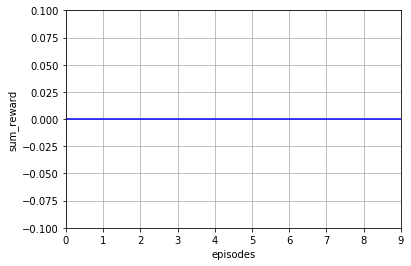

In [12]:
ddpg.logger.graph("sum_reward")

In [11]:
test_reward_list = ddpg.test()
print(test_reward_list)

-1444.0413939563243


## Plotting the test result

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(test_reward_list)
# plt.xlabel("Episodes")
# plt.ylabel("Total Rewards per Episode")